In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import  distance_matrix
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from fermat import Fermat

%reload_ext autoreload
%autoreload 2

%matplotlib inline

## Cálculo de $D_Q (x,y)$ ## 

data = puntos sobre los cuales calculamos distnacia de fermat empírica y a esta ultima le aplicamos un kernel gaussiano

In [2]:
def get_DQ(data, N, k_h=1, alpha=10, k=10, d=64, method="D"):
    distances = distance_matrix(data, data)
    f_exact = Fermat(alpha=alpha, path_method=method, k=k)
    f_exact.fit(distances)  # Esto NO puede ser una `np.matrix`, DEBE(?) ser un `np.ndarray`
    fermat_distances = f_exact.get_distances()
    h = k_h * N ** (-1 / (d + 4))
    beta = (1 - alpha) / d
    fermat_distances = np.array(
        (1 / h) * (N ** (-beta)) * fermat_distances, dtype=np.float32
    )
    # delta = 1 # Esto despues cambiarlo
    # kernel_fermat_distances = (N **2 )* np.exp(- fermat_distances ** 2 / (2. * delta ** 2))
    kernel_fermat_distances = (
        (1 / N) * (h ** (-d)) * np.exp(-1 * fermat_distances**2 / 2.0)
    )  # Le saque el delta
    # kernel_fermat_distances =  np.exp(-1* fermat_distances ** 2 / 2. )
    return kernel_fermat_distances, fermat_distances


# Generamos data de 2 lunas 

$N =$ cantidad de puntos en cada luna. La muestra es de tamaño $2N$

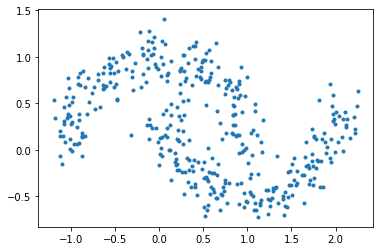

In [3]:
N = 200
n_samples = 2 * N
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.14)
xnoise = [noisy_moons[0][i][0] for i in range(2 * N)]
ynoise = [noisy_moons[0][i][1] for i in range(2 * N)]
true_labels = noisy_moons[1]
plt.plot(xnoise, ynoise, ".")


In [4]:
first_moon = np.array(
    [noisy_moons[0][i] for i in range(n_samples) if noisy_moons[1][i] == 0]
)
first_moon_x = [
    noisy_moons[0][i][0] for i in range(n_samples) if noisy_moons[1][i] == 0
]
first_moon_y = [
    noisy_moons[0][i][1] for i in range(n_samples) if noisy_moons[1][i] == 0
]
second_moon = np.array(
    [noisy_moons[0][i] for i in range(n_samples) if noisy_moons[1][i] == 1]
)
second_moon_x = [
    noisy_moons[0][i][0] for i in range(n_samples) if noisy_moons[1][i] == 1
]
second_moon_y = [
    noisy_moons[0][i][1] for i in range(n_samples) if noisy_moons[1][i] == 1
]
# plt.plot(first_moon_x,first_moon_y,'r.')
# plt.plot(second_moon_x,second_moon_y,'b.')


# Generamos data para evaluar

Tomamos *test_size* puntos de cada luna y calculamos 
Para cada $p \in  $ *noisy_moons_test* calculamos 
    $$ \sum_{q \in \text{first\_moon}}\frac{1}{nh^d} K(\frac{1}{hn^\beta}D_Q(p,q)) \qquad vs \qquad  \sum_{q \in \text{second\_moon}} \frac{1}{nh^d} K(\frac{1}{hn^\beta}D_Q(p,q))  $$
    
Obs: Los factores de normalizacion no los estoy teniendo en cuenta. Sería una especie de Naive Bayes con un nucleo y el estimador de Fermat

In [8]:
test_size = 200
noisy_moons_test = datasets.make_moons(n_samples=test_size, noise=0.14)
first_moon_test = np.array(
    [noisy_moons_test[0][i] for i in range(test_size) if noisy_moons_test[1][i] == 0]
)
second_moon_test = np.array(
    [noisy_moons_test[0][i] for i in range(test_size) if noisy_moons_test[1][i] == 1]
)


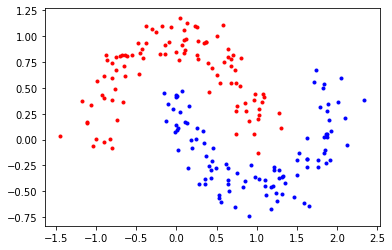

In [9]:
for i in range(test_size):
    if noisy_moons_test[1][i] == 0:
        plt.plot(noisy_moons_test[0][i][0], noisy_moons_test[0][i][1], "r.")
    else:
        plt.plot(noisy_moons_test[0][i][0], noisy_moons_test[0][i][1], "b.")


In [10]:
# distances_0 = get_DQ(data = np.concatenate((first_moon,first_moon_test,second_moon_test)))
# distances_1 = get_DQ(data = np.concatenate((second_moon,first_moon_test,second_moon_test)))fer
distances_0, fermat_distances_0 = get_DQ(
    data=np.concatenate((first_moon, noisy_moons_test[0])), k_h=1, N=N, alpha=2, d=1
)
distances_1, fermat_distances_1 = get_DQ(
    data=np.concatenate((second_moon, noisy_moons_test[0])), k_h=1, N=N, alpha=2, d=1
)


In [11]:
# Evaluamos si la suma correspondiente al cluster 0 es menor que la del cluster 1 para ver que etiqueta
# le asignamos
labels = (len(distances_0) - N) * [0]
for i in range(N, len(distances_0)):
    if np.sum(distances_0[i, :N]) < np.sum(distances_1[i, :N]):
        labels[i - N] = 1


## Resultados



## Clusters que genera 

In [12]:
def plot_clusters_2D(data, labels):
    colours = [".r", ".g", ".b"]
    for i in range(len(labels)):
        plt.plot(data[i][0], data[i][1], colours[int(labels[i])])


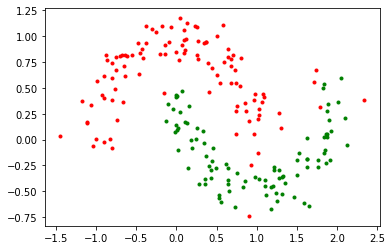

In [13]:
plot_clusters_2D(noisy_moons_test[0], labels)


In [14]:
def model_accuracy(model, labels_predict, real_labels):
    acc = 0
    for i in range(len(labels_predict)):
        if labels_predict[i] == real_labels[i]:
            acc = acc + 1
    print(
        "The accuracy of ",
        model,
        " classifier is ",
        100 * acc / len(labels_predict),
        "%",
    )


In [15]:
model_accuracy("Fermat", labels, noisy_moons_test[1])


The accuracy of  Fermat  classifier is  96.5 %


## Dos lunas con Naive Bayes ##

In [16]:
clf = GaussianNB()
moons = np.concatenate((first_moon, second_moon))
labels = np.zeros(len(moons))
labels[len(first_moon) :] = np.ones(len(second_moon))
clf.fit(moons, labels)


GaussianNB()

In [17]:
labels_predict = clf.predict(noisy_moons_test[0])


In [18]:
model_accuracy("Naive Bayes", labels_predict, noisy_moons_test[1])


The accuracy of  Naive Bayes  classifier is  85.5 %


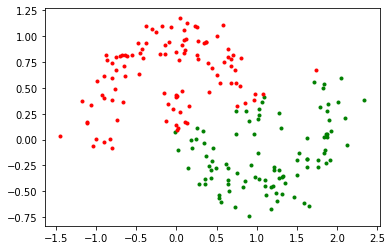

In [19]:
plot_clusters_2D(noisy_moons_test[0], labels_predict)


## Random Forest

In [20]:
# from sklearn.ensemble import RandomForestClassifier

# Instantiate
rf = RandomForestClassifier()
# Fit
rf_model = rf.fit(moons, labels)
# training accuracy
rf_model.score(moons, labels)


1.0

In [21]:
labels_predict = rf_model.predict(noisy_moons_test[0])


The accuracy of  Random Forest  classifier is  97.5 %


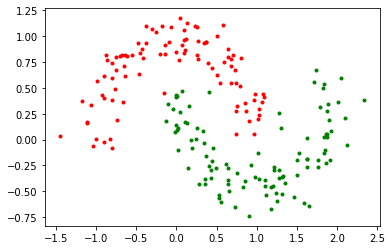

In [22]:
model_accuracy("Random Forest", labels_predict, noisy_moons_test[1])
plot_clusters_2D(noisy_moons_test[0], labels_predict)


## Digits 0-1 images

In [23]:
digits = datasets.load_digits(n_class=2)


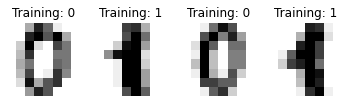

In [24]:
images_and_labels = list(zip(digits.images, digits.target))

for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis("off")
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title("Training: %i" % label)


In [25]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) / 16


In [26]:
images_0 = []
images_1 = []
n_training = 10
n_test = n_samples - n_training

images_and_labels_training = images_and_labels[:n_training]
images_and_labels_test = images_and_labels[n_training:]

for index, (image, label) in enumerate(images_and_labels_training):
    if label == 0:
        images_0.append(data[index])
    else:
        images_1.append(data[index])


In [27]:
images_0 = np.array(images_0)
images_1 = np.array(images_1)


### Digits with Fermat

In [28]:
kernel_digits_distances_0, fermat_digits_distances_0 = get_DQ(
    data=np.concatenate((images_0, data[n_training:])),
    k_h=1,
    N=n_training,
    alpha=2,
    k=20,
    d=64,
)
kernel_digits_distances_1, fermat_digits_distances_1 = get_DQ(
    data=np.concatenate((images_1, data[n_training:])),
    k_h=1,
    N=n_training,
    alpha=2,
    k=20,
    d=64,
)


In [29]:
kernel_digits_distances_0


array([[8.7332618e-01, 5.0766673e-03, 6.7062038e-03, ..., 1.5897164e-03,
        0.0000000e+00, 2.7359076e-04],
       [5.0766673e-03, 8.7332618e-01, 1.4662187e-01, ..., 5.7086152e-05,
        0.0000000e+00, 4.9572816e-04],
       [6.7062038e-03, 1.4662187e-01, 8.7332618e-01, ..., 6.3636731e-03,
        0.0000000e+00, 3.8664574e-03],
       ...,
       [1.5897164e-03, 5.7086152e-05, 6.3636731e-03, ..., 8.7332618e-01,
        0.0000000e+00, 3.0255967e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.7332618e-01, 0.0000000e+00],
       [2.7359076e-04, 4.9572816e-04, 3.8664574e-03, ..., 3.0255967e-04,
        0.0000000e+00, 8.7332618e-01]], dtype=float32)

In [30]:
labels_predict = (n_test) * [0]
offset_0 = len(images_0)
offset_1 = len(images_1)
for i in range(n_test):
    if np.sum(kernel_digits_distances_0[offset_0 + i, :offset_0]) < np.sum(
        kernel_digits_distances_1[offset_1 + i, :offset_1]
    ):
        labels_predict[i] = 1


In [31]:
model_accuracy("Fermat", labels_predict, digits.target[n_training:])


The accuracy of  Fermat  classifier is  98.85714285714286 %


### Digits with Random Forest

In [32]:
# Instantiate
rf = RandomForestClassifier()
# Fit
rf_model = rf.fit(data[:n_training], digits.target[:n_training])
# training accuracy
rf_model.score(data[:n_training], digits.target[:n_training])


1.0

In [33]:
labels_predict = rf.predict(data[n_training:])


In [34]:
model_accuracy("Random Forest", labels_predict, digits.target[n_training:])


The accuracy of  Random Forest  classifier is  98.57142857142857 %


### Digits with Naive Bayes

In [35]:
clf = GaussianNB()

clf.fit(data[:n_training], digits.target[:n_training])

clf.score(data[:n_training], digits.target[:n_training])


1.0

In [36]:
labels_predict = clf.predict(data[n_training:])


In [37]:
model_accuracy("Naive Bayes", labels_predict, digits.target[n_training:])


The accuracy of  Naive Bayes  classifier is  89.42857142857143 %


## Two circles

Generamos una muestra de tamaño *n_samples*  y genera dos círculos uniformes de tamaño *n_samples/2* con ruido *noise*

In [39]:
n_training = 100

noisy_circles = datasets.make_circles(n_samples=n_training, factor=0.2, noise=0.2)


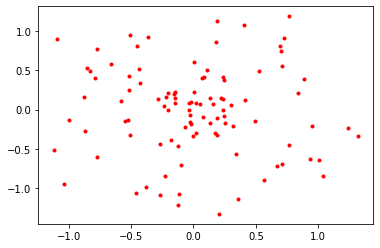

In [40]:
for i in range(n_training):
    plt.plot(noisy_circles[0][i][0], noisy_circles[0][i][1], "r.")


In [41]:
first_circle = np.array(
    [noisy_circles[0][i] for i in range(n_training) if noisy_circles[1][i] == 0]
)

second_circle = np.array(
    [noisy_circles[0][i] for i in range(n_training) if noisy_circles[1][i] == 1]
)


In [42]:
first_circle_x = [
    noisy_circles[0][i][0] for i in range(n_training) if noisy_circles[1][i] == 0
]
first_circle_y = [
    noisy_circles[0][i][1] for i in range(n_training) if noisy_circles[1][i] == 0
]

second_circle_x = [
    noisy_circles[0][i][0] for i in range(n_training) if noisy_circles[1][i] == 1
]
second_circle_y = [
    noisy_circles[0][i][1] for i in range(n_training) if noisy_circles[1][i] == 1
]


In [43]:
n_test = 1000
noisy_circles_test = datasets.make_circles(n_samples=n_test, factor=0.5, noise=0.2)
first_circle_test = np.array(
    [noisy_circles_test[0][i] for i in range(n_test) if noisy_circles_test[1][i] == 0]
)
second_circle_test = np.array(
    [noisy_circles_test[0][i] for i in range(n_test) if noisy_circles_test[1][i] == 1]
)


In [52]:
# plot_clusters_2D(noisy_circles_test[0],noisy_circles_test[1])


### Two circles with Fermat

In [53]:
kernel_circles_distances_0, fermat_circles_distances_0 = get_DQ(
    data=np.concatenate((first_circle, noisy_circles_test[0])),
    k_h=10,
    N=n_training,
    alpha=2,
    k=10,
    d=1,
)
kernel_circles_distances_1, fermat_circles_distances_1 = get_DQ(
    data=np.concatenate((second_circle, noisy_circles_test[0])),
    k_h=10,
    N=n_training,
    alpha=2,
    k=10,
    d=1,
)


In [54]:
# Evaluamos si la suma correspondiente al cluster 0 es menor que la del cluster 1 para ver que etiqueta
# le asignamos
labels_predict = n_test * [0]
for i in range(n_training // 2, n_training // 2 + n_test):
    if np.sum(kernel_circles_distances_0[i, :n_training]) < np.sum(
        kernel_circles_distances_1[i, :n_training]
    ):
        labels_predict[i - n_training // 2] = 1


The accuracy of  Fermat  classifier is  86.3 %


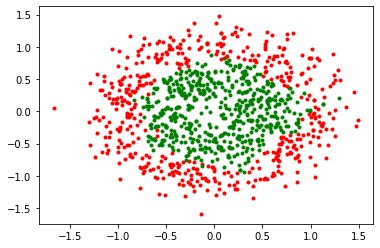

In [55]:
model_accuracy("Fermat", labels_predict, noisy_circles_test[1])
plot_clusters_2D(noisy_circles_test[0],labels_predict)


### Two circles with Random Forest

In [56]:
# Instantiate
rf = RandomForestClassifier()
# Fit
rf_model = rf.fit(noisy_circles[0], noisy_circles[1])
# training accuracy
rf_model.score(noisy_circles[0], noisy_circles[1])


1.0

In [57]:
labels_predict = rf.predict(noisy_circles_test[0])


In [58]:
model_accuracy("Random Forest", labels_predict, noisy_circles_test[1])
# plot_clusters_2D(noisy_circles_test[0],labels_predict)


The accuracy of  Random Forest  classifier is  79.3 %


### Two cirlces Naive Bayes

In [59]:
# Instantiate
gnb_model = GaussianNB()
# Fit
gnb_model = rf.fit(noisy_circles[0], noisy_circles[1])
# training accuracy
gnb_model.score(noisy_circles[0], noisy_circles[1])


1.0

In [60]:
labels_predict = gnb_model.predict(noisy_circles_test[0])


In [61]:
model_accuracy("Naive Bayes", labels_predict, noisy_circles_test[1])
# plot_clusters_2D(noisy_circles_test[0],labels_predict)


The accuracy of  Naive Bayes  classifier is  78.6 %


In [62]:
for j in range(1, 10):
    kernel_circles_distances_0, fermat_circles_distances_0 = get_DQ(
        data=np.concatenate((first_circle, noisy_circles_test[0])),
        k_h=j / 100,
        N=n_training,
        alpha=2,
        k=10,
    )
    kernel_circles_distances_1, fermat_circles_distances_1 = get_DQ(
        data=np.concatenate((second_circle, noisy_circles_test[0])),
        k_h=j / 100,
        N=n_training,
        alpha=2,
        k=10,
    )
    labels_predict = n_test * [0]
    for i in range(n_training // 2, n_training // 2 + n_test):
        if np.sum(kernel_circles_distances_0[i, :n_training]) < np.sum(
            kernel_circles_distances_1[i, :n_training]
        ):
            labels_predict[i - n_training // 2] = 1
    model_accuracy("Fermat", labels_predict, noisy_circles_test[1])


The accuracy of  Fermat  classifier is  79.3 %
The accuracy of  Fermat  classifier is  82.0 %
The accuracy of  Fermat  classifier is  84.7 %
The accuracy of  Fermat  classifier is  85.6 %
The accuracy of  Fermat  classifier is  86.2 %
The accuracy of  Fermat  classifier is  85.1 %
The accuracy of  Fermat  classifier is  81.0 %
The accuracy of  Fermat  classifier is  75.1 %
The accuracy of  Fermat  classifier is  70.1 %
